<h1>Table of contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#clean-corpus" data-toc-modified-id="clean-corpus-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>clean corpus</a></span><ul class="toc-item"><li><span><a href="#dataframe-cleaning" data-toc-modified-id="dataframe-cleaning-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>dataframe cleaning</a></span></li><li><span><a href="#text-cleaning" data-toc-modified-id="text-cleaning-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>text cleaning</a></span></li></ul></li><li><span><a href="#downsampling" data-toc-modified-id="downsampling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>downsampling</a></span></li><li><span><a href="#Add-length" data-toc-modified-id="Add-length-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add length</a></span></li><li><span><a href="#split-corpus" data-toc-modified-id="split-corpus-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>split corpus</a></span></li><li><span><a href="#split-small-corpus-for-testing-purpose" data-toc-modified-id="split-small-corpus-for-testing-purpose-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>split small corpus for testing purpose</a></span></li><li><span><a href="#different-classes-(only-3)" data-toc-modified-id="different-classes-(only-3)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>different classes (only 3)</a></span></li><li><span><a href="#different-classes-(only-3)-with-downsampling-and-rename-classes" data-toc-modified-id="different-classes-(only-3)-with-downsampling-and-rename-classes-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>different classes (only 3) with downsampling and rename classes</a></span></li><li><span><a href="#combine-results" data-toc-modified-id="combine-results-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>combine results</a></span></li><li><span><a href="#confusion-matrices" data-toc-modified-id="confusion-matrices-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>confusion matrices</a></span></li></ul></div>

**Dataset**:<br>
Amazon Reviews: https://nijianmo.github.io/amazon/index.html

In [1]:
import os
import json
import gzip
from nltk import word_tokenize
import pandas as pd
from urllib.request import urlopen

from utils import clean_text, random_downsampling

# load data

In [ ]:
""" very time consuming

data = []
with gzip.open('../corpora/Electronics_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

df = pd.DataFrame.from_dict(data)

big_corpus = df[["overall", "reviewerName", "reviewText", 
                  "summary", "verified", "vote", "reviewTime"]]
                  
big_corpus.to_csv("../corpora/amazon_reviews_electronic.csv", index=False)
"""
print("Done loading.")

# clean corpus

In [3]:
PATH = "../corpora/old/amazon_reviews_electronic_raw.csv"
MIN_YEAR = 2018
COMBINE_SUMMARY = False

In [4]:
%%time
corpus = pd.read_csv(PATH)

CPU times: user 1min 4s, sys: 18.6 s, total: 1min 23s
Wall time: 1min 45s


In [5]:
corpus.head()

,overall,reviewerName,reviewText,summary,verified,vote,reviewTime
0,5.0,D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,True,67,"09 18, 1999"
1,3.0,Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,True,5,"10 23, 2013"
2,5.0,Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,False,4,"09 2, 2008"
3,5.0,Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,False,13,"09 4, 2000"
4,3.0,W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,True,8,"02 4, 2000"


## dataframe cleaning

In [6]:
%%time
corpus.vote = corpus.vote.fillna(0)
corpus = corpus.fillna("")


# rename columns

corpus = corpus.rename(columns={"overall": "rating", 
                                "reviewerName": "name",
                                "reviewText": "review",
                                "reviewTime": "date"})

# no empty ratings, reviews & dates

corpus = corpus[corpus.rating != ""]
corpus = corpus[corpus.review != ""]
corpus = corpus[corpus.date != ""]


# change date

def change_date(date):
    day_month, year = str(date).split(",")
    month, day = day_month.split(" ")
    
    if len(day) <= 1:
        day = "0" + str(day)
        
    
    return f"{day}.{month}.{str(year)[-4:]}"

# only reviews since a specific date

def remove_dates(date, min_year):
    year = int(str(date)[-4:])
    if year < min_year:
        return ""
    else:
        return date
    
corpus.date = corpus.date.apply(lambda x: remove_dates(x, MIN_YEAR))
corpus = corpus[corpus.date != ""]

corpus.date = corpus.date.apply(lambda x: change_date(x))


# combine summary and review text

if COMBINE_SUMMARY:
    corpus['review'] = corpus[['summary', 'review']].apply(lambda x: " ".join(str(y) for y in x if str(y) != 'nan'), axis = 1)
del corpus["summary"]

/Users/jan/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


CPU times: user 31.6 s, sys: 20.2 s, total: 51.8 s
Wall time: 1min 14s


In [7]:
corpus.sample(10)

,rating,name,review,verified,vote,date
6730754,5.0,J.W.,You don't have to have the safest house on the...,True,0,02.07.2018
3986072,1.0,Jay A. Walker,I was sent the wrong case I wanted iPad one no...,True,0,16.03.2018
6091325,5.0,Customer DBG,works great and fast speed.,True,0,14.07.2018
5072103,2.0,Jake,"Looks fake, blinking light is obvious. Everyo...",True,0,11.01.2018
6628316,2.0,Kindle Customer,I loved this receiver until it died the day be...,True,0,12.02.2018
2849453,5.0,Roger T,Very happy with it,True,0,21.04.2018
3372689,5.0,Hunter Eubanks,Excellent product. Pleased with purchase,True,0,09.04.2018
3300814,3.0,Joel Jacobs,"The mounts have trouble maintaining an angle, ...",True,0,09.03.2018
2679870,5.0,John W.,what not to like?,True,0,05.02.2018
5227434,2.0,QueenBee Debbie of SheMakesTheRules,"These were super comfortable, but simply didn'...",True,0,16.01.2018


## text cleaning

In [8]:
%%time
corpus.review = corpus.review.apply(clean_text)
corpus = corpus[corpus.review != ""]

/Users/jan/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:312: UserWarning: "old" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)


CPU times: user 1min 18s, sys: 7.53 s, total: 1min 26s
Wall time: 1min 35s


In [9]:
corpus.head()

,rating,name,review,verified,vote,date
217,5.0,Problematic1963,I made a photo album for a senior friend who w...,True,0,27.01.2018
842,5.0,Tazman32,Great addition to our new Galaxy Ss which by t...,True,0,01.04.2018
843,5.0,Brian D. Carrico,Perfect,True,0,30.03.2018
844,4.0,Cici Ciconia,As described,True,0,30.03.2018
845,5.0,AJ,Great little card made my device better,True,0,27.03.2018


In [10]:
corpus.shape

(377057, 6)

In [11]:
corpus.rating.value_counts()

5.0    253232
4.0     52737
1.0     28443
3.0     25828
2.0     16817
Name: rating, dtype: int64

In [12]:
corpus.to_csv("../corpora/old/amazon_reviews_electronic.csv")

# downsampling

Reduces corpus size by random downsampling.

In [ ]:
s_corpus = random_downsampling(corpus, class_col="rating", max_value = 15000)

In [ ]:
#s_corpus.to_csv("../corpora/small_amazon_reviews_electronic.csv", index=False)

In [ ]:
s_corpus.shape

# Add length

In [4]:
def length(x):
    return len(word_tokenize(x))

corpus["length"] = corpus.review.apply(length)

In [6]:
#corpus.to_csv("../corpora/small_amazon_reviews_electronic.csv", index=False)

# split corpus

In [5]:
import pandas as pd
from utils import *

In [2]:
corpus = pd.read_csv("../corpora/small_amazon_reviews_electronic.csv")

In [4]:
split_corpus(corpus, split=0.8)

/Users/jan/Desktop/informatik_programme/wordembeddings/app/utils.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_col] = df.apply(lambda row: word_tokenize(row[text_col]), axis=1)


# split small corpus for testing purpose

In [6]:
import pandas as pd
from utils import *

corpus = pd.read_csv("../corpora/small_amazon_reviews_electronic.csv")
corpus = corpus.sample(300)
split_corpus(corpus, split=0.8, output_path = "../corpora/splitssmall/")

/Users/jan/Desktop/informatik_programme/wordembeddings/app/utils.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_col] = df.apply(lambda row: word_tokenize(row[text_col]), axis=1)


# different classes (only 3)

In [4]:
import pandas as pd
from utils import *

corpus = pd.read_csv("../corpora/small_amazon_reviews_electronic.csv")
corpus["rating"] = corpus.rating.replace(2.0, 1.0)
corpus["rating"] = corpus.rating.replace(4.0, 5.0)

#split_corpus(corpus, split=0.8, output_path = "../corpora/altersplits/")

/Users/jan/projects/wordembeddings/app/utils.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_col] = df.apply(lambda row: word_tokenize(row[text_col]), axis=1)


# different classes (only 3) with downsampling and rename classes

In [2]:
%%time
import pandas as pd
from utils import *

corpus = pd.read_csv("../corpora/old/amazon_reviews_electronic.csv")
corpus = random_downsampling(corpus, splitting=3,
                             class_col="rating", max_value = 15000)

def length(x):
    return len(word_tokenize(x))

corpus["length"] = corpus.review.apply(length)

corpus["rating"] = corpus.rating.replace(1.0, "negative")
corpus["rating"] = corpus.rating.replace(3.0, "neutral")
corpus["rating"] = corpus.rating.replace(5.0, "positive")
corpus.to_csv("../corpora/alter_small_amazon_reviews_electronic.csv", index=False)
split_corpus(corpus, split=0.8, output_path = "../corpora/altersplits/")

/Users/jan/projects/wordembeddings/app/utils.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_col] = df.apply(lambda row: word_tokenize(row[text_col]), axis=1)


CPU times: user 58.5 s, sys: 1.18 s, total: 59.7 s
Wall time: 1min 1s


# combine results

In [2]:
import glob
import os
from pathlib import Path
from collections import defaultdict
import numpy as np

In [3]:
embedding = "fasttext-en"
model = "fasttext-exp"
path = f"../results/{model}/"

results = defaultdict(list)
for file in Path(path).rglob("*.txt"):
    if embedding in file.stem:
        with open(file, "r") as f:
            s = f.read()
            if model != "bert":
                s = s[-6:-1]
                s = s.replace(" ", "")
            s = float(s)
        key = file.stem[len(embedding)+3:]
        results[key].append(s)
    
means = {}
for k, v in dict(results).items():
    means[k] = np.mean(v)
means_sorted = sorted(means.items(), key=lambda x: x[1], reverse=True)
means_sorted

[('bs128_mf75000_lr0.1', 71.48333333333333),
 ('bs128_mf50000_lr0.05', 71.39666666666666),
 ('bs128_mf75000_lr0.01', 71.29333333333334),
 ('bs256_mf75000_lr0.1', 71.26),
 ('bs256_mf50000_lr0.05', 71.23333333333333),
 ('bs128_mf50000_lr0.1', 71.13333333333333),
 ('bs128_mf75000_lr0.05', 71.04666666666667),
 ('bs128_mf50000_lr0.01', 71.03666666666668),
 ('bs256_mf75000_lr0.01', 71.01333333333334),
 ('bs256_mf50000_lr0.01', 70.93666666666667),
 ('bs256_mf75000_lr0.05', 70.83),
 ('bs256_mf50000_lr0.1', 70.78666666666666)]

# confusion matrices

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd
import seaborn as sns

def divide(x):
    return np.around(x/3, decimals=0)

cnn = pd.read_csv("../results/cm/fasttext-exp_cm/cm_fasttext-en_1_bs128_mf75000_lr0.1.csv", index_col=0)
bert1 = pd.read_csv("../results/cm/bert_cm/cm_bert_1_lr2e-05.csv", index_col=0)
bert2 = pd.read_csv("../results/cm/bert_cm/cm_bert_2_lr2e-05.csv", index_col=0)
bert3 = pd.read_csv("../results/cm/bert_cm/cm_bert_3_lr2e-05.csv", index_col=0)
bert = bert1 + bert2 + bert3
bert = bert.apply(lambda x: divide(x)).astype(int)

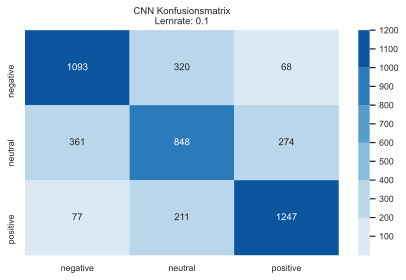

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(6, 4))
sns.set(font_scale=0.8)
sns.heatmap(cnn, 
            annot=True, 
            cmap=sns.color_palette("Blues"),
            vmin=-1,
            vmax=1200,
            cbar_kws=dict(ticks=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]),
            fmt='g')
plt.title("CNN Konfusionsmatrix\nLernrate: 0.1") #todo
plt.tight_layout()
plt.savefig("../results/cm/cmcnn.png", dpi=300)
plt.show()

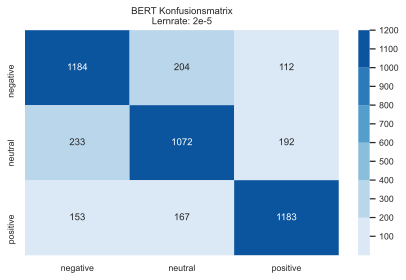

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(6, 4))
sns.set(font_scale=0.8)
sns.heatmap(bert, 
            annot=True, 
            cmap=sns.color_palette("Blues"),
            vmin=-1,
            vmax=1200,
            cbar_kws=dict(ticks=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]),
            fmt='g')
plt.title("BERT Konfusionsmatrix\nLernrate: 2e-5")
plt.tight_layout()
plt.savefig("../results/cm/cmbert.png", dpi=300)
plt.show()